## Applied Data Science Capstone Project - The Battle of Neighborhoods

### Introduction/Business Problem

An investor is looking to open a new restaurant in San Francisco, but he is not sure about the best location for his new venue and needs input for making the decision. San Francisco is rather busy city famous for its business innovation and several famous tourit attractions. So while it looks promising to set up a new restaurant business in San Francisco, the venue's location must be carefully picked in order to maximize the profit. According to <a href="https://www.foodnewsfeed.com/fsr/vendor-bylines/8-factors-choosing-new-restaurant-location">an analysis</a> in the FSR Magazine, the 8 factors for choosing a new restaurant location are

1. Visibility - look for foot and car traffic patterns that can give the venue the best visibility.
2. Parking - need to have sufficient parking space for customers.
3. Space size - consider how big of a space one needs for restaurant requirements.
4. Crime rates - avoid crime-laden areas in the city.
5. Surrounding businesses and competitor analysis - know what types of restaurant would do well in a certain area. Know what will distinguish a new restaurant from competitors.
6. Acessibility - keep in mind about things like off-the-hightway locations, locations near busy intersections.
7. Affordability - the cost of the venue space (rental or purchase) is a bottom-line consideration for any business.
8. Safety - workplace safty is important for the restaurant owner as well as workers.

In the capstone project, we will get the help from FourSquare API to address these considerations. 

### Data

Because of the availability of datasets, we will not address all of the factors listed above. However, we will work on some of the most important factors such as visibility, parking, crime rates, and affordability. We will utilize the following datasets/tools.

Static datasets:

1. Police Department Incident Reports: 2018 to Present (<a href="https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783">Link</a>). The dataset includes police incident reports filed by officers and by individuals through self-service online reporting for non-emergency cases. Reports included are those for incidents that occurred starting January 1, 2018 onward and have been approved by a supervising officer. 
2. MTA On Street Parking Census (<a href="https://data.sfgov.org/Transportation/MTA-parkingcensus_onstreet/up9y-3nmx">Link</a>). The dataset contains locations and space count of unmetered motorcycle parking for the City of San Francisco.
3. MTA Off Street Parking Census (<a href="https://data.sfgov.org/Transportation/MTA-parkingcensus_offstreet/dkzc-uy8h">Link</a>). SFMTA managed off street parking locations, hours, and amenities. Includes both lots and garages.	
4. San Francisco Historica Secured Property Tax Rolls, 2007-2015 (<a href="https://www.kaggle.com/datasf/sf-historic-secured-property-tax-rolls">Link</a>). This dataset includes the SF Office of the Assessor-Recorder’s secured property tax roll spanning from 2007 to 2015. We will use the latest data as a measure of the cost of venue space.

Search engines:
1. <a href="https://foursquare.com/">Foursquare</a>. We will use the foursquare API to carry out venue and point of interest search. The results will give us an idea of the neighborhood of the venue's potential location.
2. <a href="https://www.parkwhiz.com/">PARKWHIZ</a>. We intend to use the static dataset to look up parking space information near the potential venue location. PARKWHIZ is a quick and convenient alternative.

---

Import libraries

In [95]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib as mpl
import matplotlib.pyplot as plt
import pysal as ps

from geopandas.tools import sjoin
from geopy.geocoders import Nominatim
from folium.plugins import FastMarkerCluster
from shapely.geometry import Point

%matplotlib inline

/anaconda3/envs/mlenv/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


### SF crime data analysis

Load in San Francisco Police Department Incident Reports, 2018 - Present.

In [2]:
crime_data_path = "./Police_Department_Incident_Reports__2018_to_Present.csv"
df_crime = pd.read_csv(crime_data_path)
df_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111531 entries, 0 to 111530
Data columns (total 26 columns):
Incident Datetime          111531 non-null object
Incident Date              111531 non-null object
Incident Time              111531 non-null object
Incident Year              111531 non-null int64
Incident Day of Week       111531 non-null object
Report Datetime            111531 non-null object
Row ID                     111531 non-null int64
Incident ID                111531 non-null int64
Incident Number            111531 non-null int64
CAD Number                 86415 non-null float64
Report Type Code           111531 non-null object
Report Type Description    111531 non-null object
Filed Online               23641 non-null object
Incident Code              111531 non-null int64
Incident Category          111520 non-null object
Incident Subcategory       111520 non-null object
Incident Description       111531 non-null object
Resolution                 111531 non-null ob

In [7]:
pd.set_option('display.max_columns', 100)
df_crime.head()

Incident Datetime Incident Date Incident Time  Incident Year  \
0  2018/01/01 01:30:00 AM    2018/01/01         01:30           2018   
1  2018/01/01 01:59:00 AM    2018/01/01         01:59           2018   
2  2018/01/01 02:28:00 AM    2018/01/01         02:28           2018   
3  2018/01/01 02:28:00 AM    2018/01/01         02:28           2018   
4  2018/01/01 02:08:00 AM    2018/01/01         02:08           2018   

  Incident Day of Week         Report Datetime       Row ID  Incident ID  \
0               Monday  2018/01/01 02:13:00 AM  61870203073       618702   
1               Monday  2018/01/01 01:59:00 AM  61870768000       618707   
2               Monday  2018/01/01 02:31:00 AM  61870904134       618709   
3               Monday  2018/01/01 02:31:00 AM  61870928160       618709   
4               Monday  2018/01/01 02:08:00 AM  61871004014       618710   

   Incident Number   CAD Number Report Type Code Report Type Description  \
0        180000263  180010563.0               II                 Initial   
1        180000326  180010504.0               II                 Initial   
2        180000348  180010636.0               II                 Initial   
3        180000348  180010636.0               II                 Initial   
4        180000285  180010537.0               II                 Initial   

  Filed Online  Incident Code   Incident Category Incident Subcategory  \
0          NaN           3073             Robbery      Robbery - Other   
1          NaN          68000         Fire Report          Fire Report   
2          NaN           4134             Assault       Simple Assault   
3          NaN          28160  Malicious Mischief            Vandalism   
4          NaN           4014             Assault   Aggravated Assault   

                       Incident Description            Resolution  \
0                  Robbery, W/ Other Weapon        Open or Active   
1                               Fire Report        Open or Active   
2                                   Battery        Open or Active   
3  Malicious Mischief, Vandalism to Vehicle        Open or Active   
4             Assault, Aggravated, W/ Force  Cite or Arrest Adult   

                             Intersection         CNN Police District  \
0                 JUSTIN DR \ COLLEGE AVE  21236000.0       Ingleside   
1                    16TH ST \ MISSION ST  24170000.0         Mission   
2                      03RD ST \ PERRY ST  20657000.0        Southern   
3                      03RD ST \ PERRY ST  20657000.0        Southern   
4  CESAR CHAVEZ ST \ CAPP ST \ MISSION ST  21304000.0         Mission   

  Analysis Neighborhood  Supervisor District   Latitude   Longitude  \
0        Bernal Heights                  9.0  37.732261 -122.423486   
1               Mission                  9.0  37.765051 -122.419669   
2       South of Market                  6.0  37.782119 -122.396841   
3       South of Market                  6.0  37.782119 -122.396841   
4        Bernal Heights                  9.0  37.748166 -122.418221   

                                       point  
0  (37.732261252752224, -122.42348641495892)  
1   (37.76505133632968, -122.41966897380142)  
2   (37.78211912156566, -122.39684142850209)  
3   (37.78211912156566, -122.39684142850209)  
4   (37.74816568813204, -122.41822117169174)

Remove columns that are not needed for analysis and visualization.

In [8]:
columns = ['Incident Datetime', 'Incident Day of Week', 'Incident Year', 
           'Report Datetime', 'Row ID', 'Incident ID', 'CAD Number', 'Report Type Code', 
           'Report Type Description', 'Filed Online', 'Incident Code', 'Incident Subcategory', 
           'Incident Description', 'Intersection', 'CNN', 'Analysis Neighborhood', 
           'Supervisor District', 'Resolution', 'point']
df_crime = df_crime.drop(columns, axis=1)

In [9]:
df_crime.isnull().sum()

Incident Date           0
Incident Time           0
Incident Number         0
Incident Category      11
Police District         0
Latitude             5575
Longitude            5575
dtype: int64

Dropping rows that contain NaNs.

In [10]:
df_crime.dropna(inplace=True)
df_crime.isnull().sum()

Incident Date        0
Incident Time        0
Incident Number      0
Incident Category    0
Police District      0
Latitude             0
Longitude            0
dtype: int64

Get a list the type of incidents reported

In [11]:
df_crime['Incident Category'].unique()

array(['Robbery', 'Fire Report', 'Assault', 'Malicious Mischief',
       'Larceny Theft', 'Non-Criminal', 'Miscellaneous Investigation',
       'Disorderly Conduct', 'Warrant', 'Weapons Carrying Etc',
       'Recovered Vehicle', 'Other Miscellaneous', 'Burglary',
       'Missing Person', 'Suspicious Occ', 'Civil Sidewalks', 'Fraud',
       'Motor Vehicle Theft', 'Traffic Violation Arrest', 'Drug Offense',
       'Weapons Offense', 'Offences Against The Family And Children',
       'Stolen Property', 'Lost Property', 'Other Offenses',
       'Traffic Collision', 'Suicide', 'Homicide', 'Vehicle Misplaced',
       'Other', 'Family Offense', 'Forgery And Counterfeiting',
       'Sex Offense', 'Arson', 'Courtesy Report', 'Case Closure',
       'Gambling', 'Drug Violation', 'Prostitution', 'Juvenile Offenses',
       'Embezzlement', 'Vehicle Impounded', 'Vandalism',
       'Human Trafficking (A), Commercial Sex Acts', 'Liquor Laws',
       'Suspicious', 'Motor Vehicle Theft?', 'Rape', 'Weapo

Notice the 'Non-Criminal' category. These reports should be dropped from the dataset, because they are not supposed to be included in the crime data analysis.

In [12]:
df_crime = df_crime[df_crime['Incident Category'] != 'Non-Criminal'].reset_index(drop=True)

Now we visualize the number of incidents for each report category

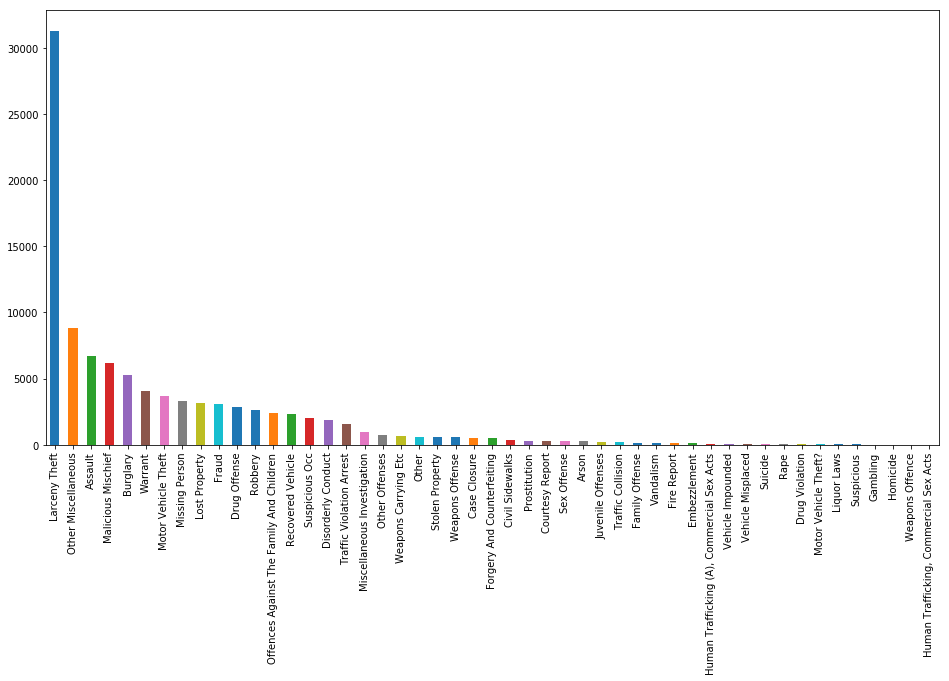

In [13]:
df_crime['Incident Category'].value_counts().plot(kind='bar', figsize=(16,8))
plt.show()

The number one category is larceny thefy, following by assault and burglary, not including 'Other Miscellaneous' and 'Miscellaneous Mischief.'

### Crime data visualization
We first convert *df_crime* DataFrame into a GeoPandas GeoDataFrame, a spatial version of *df_crime*. This is done by first creating Shapely point geometry objects with a proper coordinate projection for each record. Then we attach the results as a new column to *df_crime*.

Step 1. Creating Shapely object for each record. Details of the coordinate system, ESPG 4326 which represents the standard WGS84 coordinate system, can be found in <a href="http://geopandas.org/projections.html">this link</a>. Here we implement the __Point()__ function from the __shapely__ package.

In [14]:
geometry = gpd.GeoSeries(df_crime.apply(lambda z: Point(z['Longitude'], z['Latitude']), 1), crs={'init': 'epsg:4326'})

Step 2. Conver df_crime into GeoDataFrame. The original Latitude and Longitude columns are dropped, since they are no longer needed.

In [15]:
df_crime = gpd.GeoDataFrame(df_crime.drop(['Latitude', 'Longitude'], 1), geometry=geometry)

In [16]:
df_crime.head()

Incident Date Incident Time  Incident Number   Incident Category  \
0    2018/01/01         01:30        180000263             Robbery   
1    2018/01/01         01:59        180000326         Fire Report   
2    2018/01/01         02:28        180000348             Assault   
3    2018/01/01         02:28        180000348  Malicious Mischief   
4    2018/01/01         02:08        180000285             Assault   

  Police District                                      geometry  
0       Ingleside  POINT (-122.4234864149589 37.73226125275223)  
1         Mission  POINT (-122.4196689738014 37.76505133632968)  
2        Southern  POINT (-122.3968414285021 37.78211912156566)  
3        Southern  POINT (-122.3968414285021 37.78211912156566)  
4         Mission  POINT (-122.4182211716917 37.74816568813204)

To visualize the crime data, we could work at the police district level or on a finer scale such as census tracts. Here we choose the latter in order to give a better idea how the crime data look like neighborhood by neighborhood. First we load in the tract data obtained from <a href="https://data.sfgov.org/Geographic-Locations-and-Boundaries/Analysis-Neighborhoods-2010-census-tracts-assigned/bwbp-wk3r">DataSF</a>. After exporting the shape file, we can import them easily using GeoPandas.

In [61]:
tracts = gpd.read_file('sf_census_tracts.shp')

In [62]:
tracts.head()

geoid             nhood    shape_area     shape_len tractce10  \
0  06075016400      Hayes Valley  3.326589e+06   7589.679396    016400   
1  06075016100  Western Addition  3.970259e+06   8525.808755    016100   
2  06075015900  Western Addition  3.179072e+06   8000.966619    015900   
3  06075015500         Japantown  3.364565e+06  12144.016761    015500   
4  06075015300   Pacific Heights  2.515363e+06   6918.268026    015300   

                                            geometry  
0  POLYGON ((-122.4324669997095 37.77375700028448...  
1  POLYGON ((-122.4235409996432 37.77967400025458...  
2  POLYGON ((-122.4246870001921 37.78533500040309...  
3  POLYGON ((-122.4246870001921 37.78533500040309...  
4  POLYGON ((-122.4349179998128 37.78587599994257...

Using GeoPandas' __sjoin__ function, we can calculate the number of crimes in each census tract. Since we want to aggregate the number for each census tract, we set op='within.' The combined GeoDataFrame is further aggregated by each tract's geoid. The results are sent to become a column of the tract GeoDataFrame.

In [88]:
tract_crime_counts = gpd.tools.sjoin(df_crime, tracts, how="inner", op='intersects').groupby('geoid').size()
tract_crime_counts = pd.DataFrame(data=tract_crime_counts.reset_index())
tract_crime_counts.columns=['geoid', 'incident_counts']
tract_crime_counts.head()

geoid  incident_counts
0  06075010100             2774
1  06075010200             1351
2  06075010300              367
3  06075010400              261
4  06075010500             1517

Finally, we combine the tract_crime_counts DataFrame and the tracts GeoDataFrame using GeoPandas' merge function. We use __geoid__ as the key where the two frames are combined. Details of the implementation can be found <a href="http://geopandas.org/mergingdata.html">here</a>.

In [89]:
tracts = tracts.merge(tract_crime_counts, on='geoid')

In [90]:
tracts.head()

geoid             nhood    shape_area     shape_len tractce10  \
0  06075016400      Hayes Valley  3.326589e+06   7589.679396    016400   
1  06075016100  Western Addition  3.970259e+06   8525.808755    016100   
2  06075015900  Western Addition  3.179072e+06   8000.966619    015900   
3  06075015500         Japantown  3.364565e+06  12144.016761    015500   
4  06075015300   Pacific Heights  2.515363e+06   6918.268026    015300   

                                            geometry  incident_counts  
0  POLYGON ((-122.4324669997095 37.77375700028448...              531  
1  POLYGON ((-122.4235409996432 37.77967400025458...              815  
2  POLYGON ((-122.4246870001921 37.78533500040309...              803  
3  POLYGON ((-122.4246870001921 37.78533500040309...             1041  
4  POLYGON ((-122.4349179998128 37.78587599994257...              126

---

In [132]:
pd.DataFrame(tracts).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195 entries, 0 to 194
Data columns (total 7 columns):
geoid              195 non-null object
nhood              195 non-null object
shape_area         195 non-null float64
shape_len          195 non-null float64
tractce10          195 non-null object
geometry           195 non-null object
incident_counts    195 non-null int64
dtypes: float64(2), int64(1), object(4)
memory usage: 12.2+ KB


In [167]:
# Define San Francisco GPS location. This information can be acquired using the query in the last cell.
SF_Coord = (37.7792808, -122.4192363)

# Create San Francisco base map
SF_map = folium.Map(location=SF_Coord, zoom_start=12)

In [164]:
tracts_wgs84 = tracts.to_crs({'init': 'epsg:4326'})

data = pd.DataFrame(tracts.drop(columns='geometry'))
data = data[['geoid', 'incident_counts']]

In [176]:
tracts_wgs84.to_json()

'{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {"geoid": "06075016400", "nhood": "Hayes Valley", "shape_area": 3326589.16121, "shape_len": 7589.67939621, "tractce10": "016400", "incident_counts": 531}, "geometry": {"type": "Polygon", "coordinates": [[[-122.43246699970955, 37.773757000284476], [-122.43410899967294, 37.773549000116546], [-122.43575099987291, 37.773346000322704], [-122.43742299972494, 37.77313300000788], [-122.43908900043164, 37.77292200040868], [-122.44073499971395, 37.772712999793214], [-122.44092200041324, 37.773634999987], [-122.44110999944766, 37.77456700045043], [-122.44130000051308, 37.77550500034639], [-122.44148799989667, 37.77643500023771], [-122.44034000027708, 37.776579999867224], [-122.4398440000675, 37.77664400043605], [-122.43817700030708, 37.77685599987168], [-122.43650699980493, 37.77706799963179], [-122.4348639999343, 37.777280999613424], [-122.43321900003588, 37.7774899998089], [-122.4330279996317, 37.7765499999

In [169]:
tracts_geojson = r'sf_census_tracts.geojson'

In [170]:
SF_map.choropleth(geo_data     = tracts_geojson,
                  data         = data,
                  columns      = ['geoid', 'incident_counts'], 
                  key_on       = 'feature.properties.geoid',
                  fill_color   = 'YlOrRd', 
                  fill_opacity = 0.75, 
                  line_opacity = 0.55,
                  legend_name  = 'Number of incidents'
                 )

In [171]:
display(SF_map)

In [107]:
def add_choropleth(mapobj, gdf, id_field, value_field, fill_color = 'YlOrRd', fill_opacity = 0.6, 
                    line_opacity = 0.2, num_classes = 5, classifier = 'Fisher_Jenks'):
    #Allow for 3 Pysal map classifiers to display data
    #Generate list of breakpoints using specified classification scheme. List of breakpoint will be input to choropleth function
    if classifier == 'Fisher_Jenks':
        threshold_scale=ps.esda.mapclassify.Fisher_Jenks(gdf[value_field], k = num_classes).bins.tolist()
    if classifier == 'Equal_Interval':
        threshold_scale=ps.esda.mapclassify.Equal_Interval(gdf[value_field], k = num_classes).bins.tolist()
    if classifier == 'Quantiles':
        threshold_scale=ps.esda.mapclassify.Quantiles(gdf[value_field], k = num_classes).bins.tolist()
    
    #Convert the GeoDataFrame to WGS84 coordinate reference system
    gdf_wgs84 = gdf.to_crs({'init': 'epsg:4326'})
    
    #Call Folium choropleth function, specifying the geometry as a the WGS84 dataframe converted to GeoJSON, the data as 
    #the GeoDataFrame, the columns as the user-specified id field and and value field.
    #key_on field refers to the id field within the GeoJSON string
    mapobj.choropleth(geo_data     = gdf.to_json(),
                      data         = gdf,
                      columns      = [id_field, value_field], 
                      key_on       = 'feature.properties.{}'.format(id_field),
                      fill_color   = fill_color, 
                      fill_opacity = fill_opacity, 
                      line_opacity = line_opacity)
    return mapobj

In [108]:
#Update basemap with choropleth
SF_map = add_choropleth(SF_map, tracts, 'tractce10', 'incident_counts')
SF_map

TypeError: argument of type 'NoneType' is not iterable

In [ ]:
# Fech part of the dataset for demonstration purpose. This would speedup the folium map generation time.
Max_Records = 3000
df = df_crime[:Max_Records]

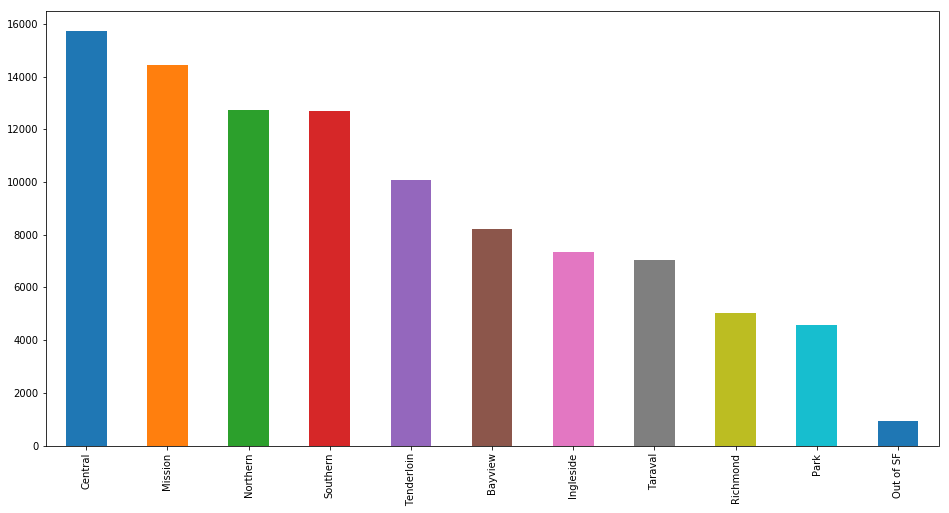

In [92]:
df_crime['Police District'].value_counts().plot(kind='bar', figsize=(16,8))
plt.show()

In [ ]:
# Query San Francisco GPS coordinates.

#address = 'San Francisco, CA, USA'
#geolocator = Nominatim(user_agent="my-application")
#location = geolocator.geocode(address)
#latitude = location.latitude
#longitude = location.longitude
#print(latitude)
#print(longitude)

In [117]:
# Define San Francisco GPS location. This information can be acquired using the query in the last cell.
SF_Coord = (37.7792808, -122.4192363)

# Fech part of the dataset for demonstration purpose. This would speedup the folium map generation time.
Max_Records = 3000
df = df_crime[:Max_Records]

In [119]:
df_crime.head()

Incident Date Incident Time  Incident Number   Incident Category  \
index_left                                                                    
0             2018/01/01         01:30        180000263             Robbery   
1             2018/01/01         01:59        180000326         Fire Report   
2             2018/01/01         02:28        180000348             Assault   
3             2018/01/01         02:28        180000348  Malicious Mischief   
4             2018/01/01         02:08        180000285             Assault   

           Police District                                      geometry  
index_left                                                                
0                Ingleside  POINT (-122.4234864149589 37.73226125275223)  
1                  Mission  POINT (-122.4196689738014 37.76505133632968)  
2                 Southern  POINT (-122.3968414285021 37.78211912156566)  
3                 Southern  POINT (-122.3968414285021 37.78211912156566)  
4                  Mission  POINT (-122.4182211716917 37.74816568813204)

In [177]:
# definition of SF police district boundaries
district_geo = r'sf_pd_districts.geojson'
  
# calculating total number of incidents per district
crimedata = pd.DataFrame(df_crime['Police District'].value_counts().astype(float))
crimedata = crimedata.reset_index()
crimedata.columns = ['District', 'Number']

# Convert district names to all capitals in order to match the geojson file.
crimedata['District'] = crimedata['District'].str.upper()
  
# creation of the choropleth
SF_map = folium.Map(location=SF_Coord, zoom_start=12)

#SF_map.add_child(FastMarkerCluster(df[['Latitude', 'Longitude']].values.tolist()))

SF_map.choropleth(geo_data     = district_geo, 
                  data         = crimedata,
                  columns      = ['District', 'Number'],
                  key_on       = 'feature.properties.DISTRICT',
                  fill_color   = 'YlOrRd', 
                  fill_opacity = 0.75, 
                  line_opacity = 0.55,
                  legend_name  = 'Number of incidents'
                 )
SF_map

In [ ]:
tract_counts

In [ ]:
tract_counts.groupby('geoid').count().astype(float)

In [ ]:
df_copy

In [ ]:
df_crime